In [29]:
#Imports
import xarray as xr
import numpy as np
from collections import OrderedDict
import csv
import matplotlib.pyplot as plt
from cartopy import config
import cartopy.crs as ccrs


In [30]:
# Returns equvalent to cdo fldmean
def fldmean(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"
    ds_weighted = ds.weighted(weights)
    return ds.mean(("lon", "lat"))

In [31]:
obs_path='obs/'
model_path='input/'
out_path='output/'

In [32]:
#Loading obs data
'''
variables = {
    'siconc':'OSISAF',
    'tas':'ERA5',
    'clt':'MODIS',
    'pr':'GPCP',
    'rlut':'CERES',
    'uas':'ERA5',
    'vas':'ERA5',
    'ua':'ERA5',
    'zg':'ERA5'}
'''
variables = {
    'tas':'ERA5',
    'pr':'GPCP',
    'uas':'ERA5',
    'vas':'ERA5',
    'ua':'ERA5',
    'zg':'ERA5'}

seasons = ['MAM', 'JJA', 'SON', 'DJF']

ds_obs = OrderedDict()
for var in variables:
    for seas in seasons:
        intermediate = xr.open_dataset(obs_path+var+'_'+variables[var]+'_'+seas+'.nc')
        ds_obs[var,seas] = intermediate.compute()

In [36]:
#Loading model data
models = ['ECE','BCC','NESM3','SNU','CAMS','NOAA-GFDL','HadGEM3MM','MRI']
time = '198912-201411'

ds_model = OrderedDict()

for model in models:
    for var in variables:
        if (var == 'uas' or var == 'vas') and model == 'SNU':
            continue
        for seas in seasons:
            intermediate = xr.open_dataset(model_path+var+'_'+model+'_'+time+'_'+seas+'.nc')
            ds_model[var,seas,model] = intermediate.compute()

In [37]:
#Define regions
regions={'glob' : {
    'lat_min':-90,
    'lat_max':90,
    'lon_min':0,
    'lon_max':360},
         
    'tropics' : {
    'lat_min':-30,
    'lat_max':30,
    'lon_min':0,
    'lon_max':360},
         
    'innertropics' : {
    'lat_min':-15,
    'lat_max':15,
    'lon_min':0,
    'lon_max':360},
         
    'antarctic' : {
    'lat_min':-90,
    'lat_max':-60,
    'lon_min':0,
    'lon_max':360},
         
    'arctic' : {
    'lat_min':60,
    'lat_max':90,
    'lon_min':0,
    'lon_max':360},
         
    'southmid' : {
    'lat_min':-90,
    'lat_max':-60,
    'lon_min':0,
    'lon_max':360},
         
    'northmid' : {
    'lat_min':30,
    'lat_max':60,
    'lon_min':0,
    'lon_max':360}}


In [38]:
#Calculate absolute error and build field mean of abs error
abs_error = OrderedDict()
mean_error = OrderedDict()
for var in variables:
    for region in regions:
        if var == 'siconc' and (region != 'arctic' and region != 'antarctic'):
            continue
        filter1 = ds_model[var,seas,model].drop('time').lat>regions[region]['lat_min']
        filter2 = ds_model[var,seas,model].drop('time').lat<regions[region]['lat_max']
        for model in models:
            if (var == 'uas' or var == 'vas') and model == 'SNU':
                continue
            for seas in seasons:
                abs_error[var,seas,model,region]=np.sqrt((ds_model[var,seas,model].drop('time').where(filter1 & filter2)-
                                                   ds_obs[var,seas].drop('time')).where(filter1 & filter2)*
                                                  (ds_model[var,seas,model].drop('time').where(filter1 & filter2)-
                                                   ds_obs[var,seas].drop('time').where(filter1 & filter2)))
                mean_error[var,seas,model,region] = fldmean(abs_error[var,seas,model,region])

In [45]:
#Write field mean of errors into csv files
for model in models:
    with open('/p/project/chhb19/streffing1/software/cmpi-tool/'+model+'.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=' ',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for region in regions:
            for var in variables:
                if (var == 'uas' or var == 'vas') and model == 'SNU':
                    continue
                for seas in seasons:
                    if var == 'tas'; then:
                        writer.writerow([var,region,seas,mean_error[var,seas,model,region].tas.values[0]])
                    if (var == 'uas') then:
                        writer.writerow([var,region,seas,mean_error[var,seas,model,region].uas.values[0]])
                    if (var == 'vas') then:
                        writer.writerow([var,region,seas,mean_error[var,seas,model,region].vas.values[0]])
                    if (var == 'ua') then:
                        writer.writerow([var,region,seas,mean_error[var,seas,model,region].ua.values[0]])
                    if (var == 'zg') then:
                        writer.writerow([var,region,seas,mean_error[var,seas,model,region].zg.values[0]])
                    if (var == 'pr') then:
                        writer.writerow([var,region,seas,mean_error[var,seas,model,region].pr.values[0]])
                    if (var == 'rlut') then:
                        writer.writerow([var,region,seas,mean_error[var,seas,model,region].rlut.values[0]])
                    if (var == 'clt') then:
                        writer.writerow([var,region,seas,mean_error[var,seas,model,region].clt.values[0]])
                    if (var == 'siconc') then:
                        writer.writerow([var,region,seas,mean_error[var,seas,model,region].siconc.values[0]])

SyntaxError: invalid syntax (1618694317.py, line 10)

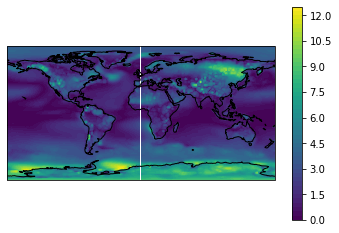

In [155]:
tas = abs_error[var,'MAM','ECE'].variables['tas'][0, :, :]
lats = abs_error[var,'MAM','ECE'].variables['lat'][:]
lons = abs_error[var,'MAM','BCC'].variables['lon'][:]

ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lons, lats, tas, 60,
             transform=ccrs.PlateCarree())

ax.coastlines()

# Add a color bar
plt.colorbar(ax=ax, shrink=.98)
plt.show()